# Galaxy zoo classifier

- Moreno Triana Jhon Sebastián
- Nisha
- Tica Christian

The project aims to get a Random Forest classifier model to classify galxy images from the [Galaxy Zoo 2 project](https://data.galaxyzoo.org/#section-7) by doing all the usual steps on a machine learning (ML) project.

1. **Random Image Selection** (Moreno Triana Jhon Sebastián)
   - We start by randomly selecting subset of image from the image dataset.

1. **Convert Images into Tabular Format** (Tica Christian)
   - Convert arrays of pixels into tabular data by treating each pixel as a feature column, with pixel intensity values as the data points.

3. **EDA and Feature Preprocessing** (Nisha)
   - Perform Exploratory Data Analysis (EDA) to understand the dataset distribution, check for missing values, normalize pixel values.

4. **Dimensionality Reduction** (Nisha)
   - Test how much we can reduce the dimensionality of the problem using one of the algorithms (PCA, kPCA, etc.).

5. **Symmetry Estimation** (Moreno Triana Jhon Sebastián)
   - Estimate the symmetry of the preprocessed images with respect to **12 axes** and add this information to the dataset.

6. **Cluster Analysis**
   - Determine how many clusters can be associated with the joint distribution of the data points using **t-SNE** or **UMAP**.

7. **Model Selection**
   - Build the classifier using **Random Forest** (experimenting with different tree depths and numbers).

8. **Model Training**
   - Train the classifier on the processed dataset.

9. **Prediction**
   - Use the trained classifier to predict class labels for the test images.

## Index

**Add Index**

> <font color='red'><b>!IMPORTANT</b></font>
> 
> <font color='red'>We suggest you to read the [README.md](./README.md) file that is with this file before you run the cells.</font>

You can use this notebook to write the ML pipeline for the classification of the galaxies in the GALAXYZOO dataset or create a folder with different files associated to the different steps of the ML pipeline.

In [1]:
#Importing libraries

import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#import Random forest classifiers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Downloading the Galaxy Zoo Dataset

You can find the dataset from the Github repository at the url:



https://www.kaggle.com/competitions/galaxy-zoo-the-galaxy-challenge/data

---

#### Create a data frame with columns for objid and the corresponding asset_id.  
- asset_id: an integer that corresponds to the filename of the image of a particular galaxy.
- objid is the designation of the galaxy, e.g. galaxy 587722981741363294

In [2]:
from src.get_files import write_file_list

write_file_list(1_500, overwrite=True)

Using 300 images from each class
Available classes:
	Ei:	 Eliptic galaxies of type i
	S:	 Spiral galaxy
	Er:	 Eliptic galaxies of type r
	Ec:	 Eliptic galaxies of type c
	SB:	 Barred spiral galaxies


In [3]:
import pandas as pd 

# get the objid and corresponding asset_id from gz2_filename_mapping.csv
columns_to_keep = ['objid', 'asset_id']

# Read the selected columns from the file
name_map = pd.read_csv("data/gz2_filename_mapping.csv", usecols=columns_to_keep)

# display the first few rows
# print(name_map.head(5))

#name_map.info()

---

#### Create a data frame with dr7objid and corresponding label. 
- dr7objid gives the galaxy designation same as objid from the previous data frame.
- label correspond to some classification of the galaxy based on its shape and morphology. 

In [4]:
# select columns dr7objid and gz2class from zoo2MainSpecz.csvW
columns_to_keep = ['dr7objid', 'gz2class']

# Read the selected columns from the file
labels = pd.read_csv("data/zoo2MainSpecz.csv", usecols=columns_to_keep)

# change the name of column dr7objid to objid for merging later
labels.rename(columns={'dr7objid':'objid'}, inplace=True)

# display
#print(labels.head(5))

#labels.info()


---

### 1. Convert array of pixels in rows of a tabular dataset,using single pixels as feature columns and the intensities as values measured (Chris)

In [5]:
# Merge labels and name_map dataframes to map asset_id to gz2class
# merge based on objid. use an inner join (only matching rows) 
# since only a subset of points in labels are in name_map, ann inner join 
# will include the rows from name_map that have matching gz2class values
# this will avoid NaNs

labels_mapped = pd.merge(name_map, labels, on='objid', how='inner' ) 


labels_mapped.describe() # should have the same number of rows as the dataframe labels

,objid,asset_id
count,2.435000e+05,243500.000000
mean,5.878182e+17,142391.360846
std,1.824223e+14,81655.120603
min,5.877230e+17,3.000000
25%,5.877327e+17,71992.750000
50%,5.877393e+17,141183.500000
75%,5.877449e+17,213104.250000
max,5.888489e+17,295305.000000


In [6]:
from dask import delayed, compute
import os 
from PIL import Image, ImageOps
from numpy import asarray

In [7]:
%%time
# parallel implementation of processing the images with DASK

from src.data_processing import process_image_dask

# Directory containing images
image_dir = "data/images"

# Get list of image file paths
image_files = [
    os.path.join(image_dir, f) for f in os.listdir(image_dir)
    if f.endswith(('.png', '.jpg'))
]

# Parallel execution using Dask
delayed_results = [process_image_dask(img) for img in image_files]
results = compute(*delayed_results)

# Filter out failed reads
results = [res for res in results if res is not None]

# Convert to Dask DataFrame
image_names, data = zip(*results)
image_data = pd.DataFrame(data)
image_data.insert(0, "asset_id", image_names)

#print(galaxy_data.head())

#image_data.info()

# Save to CSV
#df.to_csv("image_pixel_data.csv", index=False)
#print("Processing complete. Data saved to 'image_pixel_data.csv'.")


CPU times: user 1min 7s, sys: 10.9 s, total: 1min 18s
Wall time: 1min 36s


In [8]:
# Merge labels_mapped with image_data to insert gz2class columnt to the latter 
# Merge based on asset_id and use an inner join. image_data which is our 
# main data frame will only have, in general, a subset of data points (galaxies)
# in labels_mapped. 
# convert asset_id values in image_data from object to int64 before mergeing

#merge
galaxy_data = pd.merge(labels_mapped, image_data, on='asset_id', how='inner') 

# Move gz2class to the last position to serve as labels
galaxy_data['gz2class'] = galaxy_data.pop('gz2class')  

# print
print(galaxy_data.head(5))
galaxy_data['gz2class'] = galaxy_data['gz2class'].str[:2].replace(r"\bS[a-z]\w*", "S", regex = True)

print(galaxy_data['gz2class'].value_counts())
print(galaxy_data[galaxy_data['gz2class'] == 'A'])
galaxy_data.info()

                objid  asset_id   0   1  2  3  4  5  6  7  ...  179767  \
0  587722981747196080        76  12   9  6  6  7  8  6  4  ...      26   
1  587722981747916880        84   2   1  0  0  0  2  3  4  ...       3   
2  587722982281052314       203   5   5  5  5  5  5  5  5  ...       2   
3  587722982287606027       342  11  10  9  8  7  7  7  7  ...       5   
4  587722982829130044       785   2   2  2  2  2  3  3  3  ...       5   

   179768  179769  179770  179771  179772  179773  179774  179775  gz2class  
0      16      12       7       2       1       1       3       6        Sb  
1       2       3       3       3       3       2       1       0        Ei  
2       3       8      11       9       4       0       1       3        Er  
3       0       0       0       0       0       1       3       3        Ec  
4       4       5       5       6       6       5       5       4       SBb  

[5 rows x 179779 columns]
gz2class
S     300
Ei    300
Er    300
Ec    300
SB    300
N

---

### 2. Perform EDA and feature preprocessing (Nisha)
#### 2.1 Exploratory Data Analysis (EDA)

In [9]:
# print
#print(galaxy_data.head(4))

print(galaxy_data.shape)  # Check dimensions

galaxy_data.info()# Check data types & missing values

# print(galaxy_data.describe())  # Get summary stats

(1500, 179779)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Columns: 179779 entries, objid to gz2class
dtypes: int64(2), object(1), uint8(179776)
memory usage: 257.2+ MB


## Adding the symmetry data

For this kind of images we can get the symmetry information given some axis in order to add a new data that can be relevant to the data frame. In the python module named `get_symmetry` inside of the `src/` folder we define a pair of functions that given an array of images and the number of axis of symmetry we compute the differences between the intensity values of each pixel pair.

The process of getting the symmetries is the following one:

1. Get the coordinates of each pixel.
2. Rotate the coordinate system in an angle $ \theta = \dfrac{i * \pi }{n\_axis} $. Where $i$ is a number that goes from 0 to $ \dfrac{n\_axis}{2}$ and $n_axis$ is the number of axis of symmetry
3. Ignore the data that is outside of a circle of radius width of the image and centered in the middle of the image.
4. Split the image in the upper and the lower part, reflect the left part and compute the distance and append to the vector that stores the symmetry values.
5. Split the image in the left and right part, reflect the right part and compute the distance and append to the vector that stores the symmetry values.
6. Repeat until $i = \dfrac{n\_axis}{2}$.
7. Return the vector with the symmetry values.

For instance, an example of the step 5 is showing on the next image:

![assets/symmetries.png](assets/symmetries.png)

Lower the distance (darker the image) more symmetric the original image.

Then, we have the following code:

In [10]:
# Import the function from the module
from src.get_symmetry import get_all_symmetries

# Get the data related with the pixels
get_images_column = np.linspace(0, 424*424-1, 424*424)
# Reshape the image and assign it to an array
images_array = np.reshape(galaxy_data[get_images_column].to_numpy(), shape = (galaxy_data.shape[0], 424, 424))

In [11]:
%%time
from os.path import isfile
  
# Chossing the number of axis
axis = 12

# Defining the column names
columns = [f"axis-{i}" for i in range(axis)]
file_path = f'./src/{galaxy_data.shape[0]}_symmetry_{axis}.csv'

if isfile(file_path):
    galaxy_data = pd.merge(galaxy_data, pd.read_csv(file_path), on='asset_id', how='inner')
else:
    # Getting the data
    sym_data = get_all_symmetries(images_array, axis)

    # Appending to the data frame
    for i in range(axis):
        galaxy_data[columns[i]] = sym_data[:,i]

    galaxy_data[["asset_id" ,*columns]].to_csv(file_path)

galaxy_data['gz2class'] = galaxy_data.pop('gz2class')

galaxy_data.columns = galaxy_data.columns.astype(str)

galaxy_data[["asset_id", *columns]].describe()

CPU times: user 178 ms, sys: 25.2 ms, total: 203 ms
Wall time: 205 ms


,asset_id,axis-0,axis-1,axis-2,axis-3,axis-4,axis-5,axis-6,axis-7,axis-8,axis-9,axis-10,axis-11
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,141618.813333,3.030642,3.037365,2.987975,2.970916,3.001762,2.964659,3.029757,2.976157,3.032344,2.963562,3.006437,2.954432
std,81308.911685,1.278737,1.417701,1.296762,1.394033,1.334434,1.376482,1.401972,1.356298,1.443199,1.326700,1.438765,1.298592
min,76.000000,1.305469,1.144435,1.288453,1.177693,1.304345,1.236439,1.246946,1.070249,1.279120,1.155466,1.333220,1.295395
25%,71526.750000,2.254558,2.235404,2.205261,2.172978,2.206301,2.162747,2.195901,2.144779,2.189790,2.151194,2.179262,2.160358
50%,140707.500000,2.696486,2.696077,2.649311,2.633872,2.668329,2.626766,2.657104,2.598270,2.653775,2.629583,2.638069,2.627406
75%,210892.500000,3.382755,3.363507,3.342027,3.303423,3.366672,3.315484,3.406100,3.378663,3.408297,3.355383,3.337292,3.327463
max,294627.000000,15.773980,18.756775,16.711391,16.406589,18.803361,16.414505,19.823208,16.026322,20.155071,15.012844,19.823758,14.389785


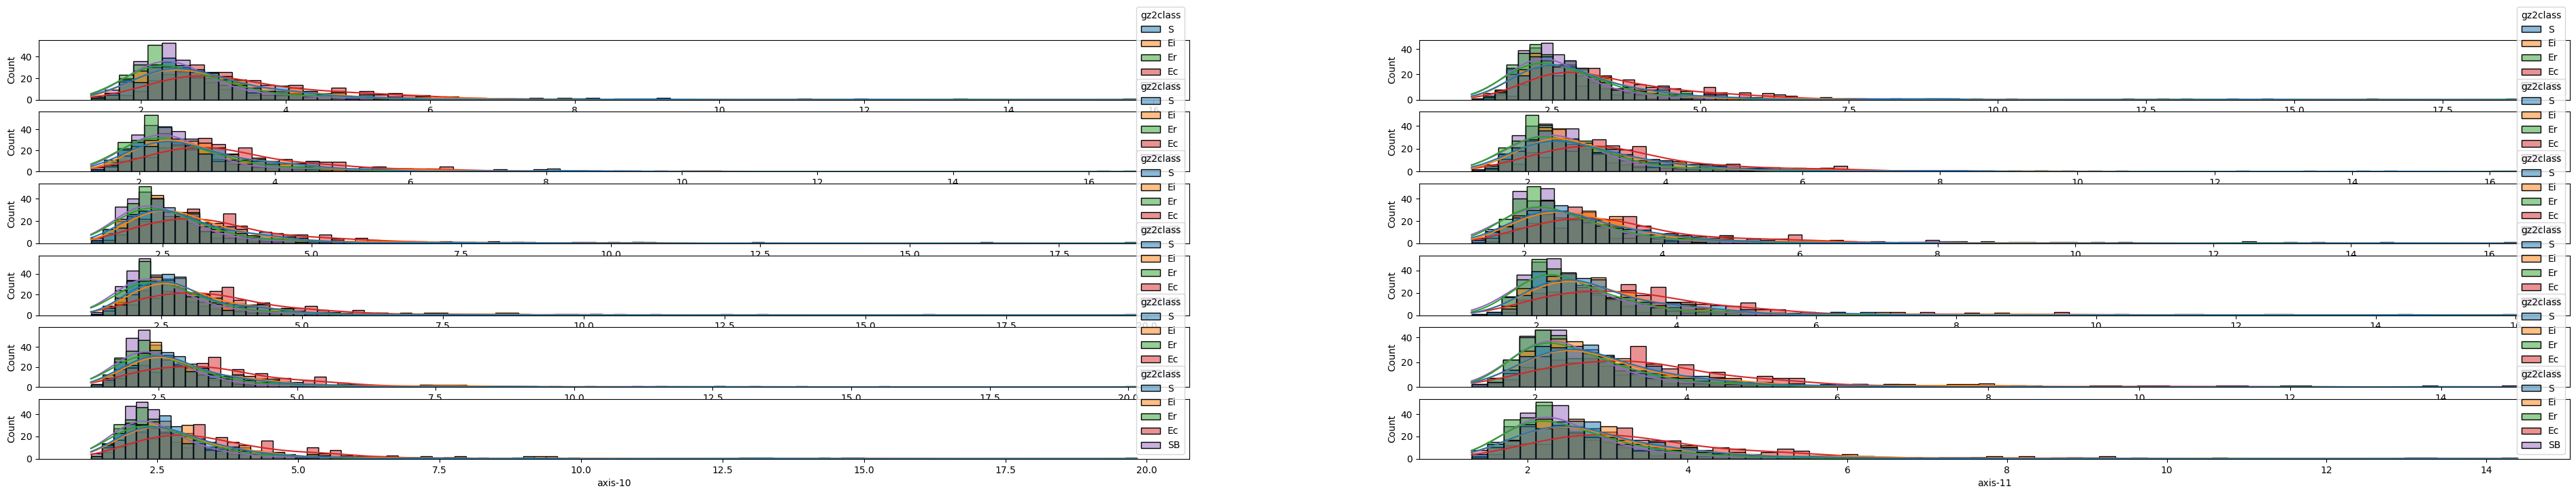

In [12]:
import seaborn as sns

fig, fig_axis = plt.subplots(axis//2, 2, figsize = (8*axis//2, 8))

for i in range(axis):
    sns.histplot(data=galaxy_data, x=f"axis-{i}", hue="gz2class", kde=True, ax = fig_axis[i//2, i%2])

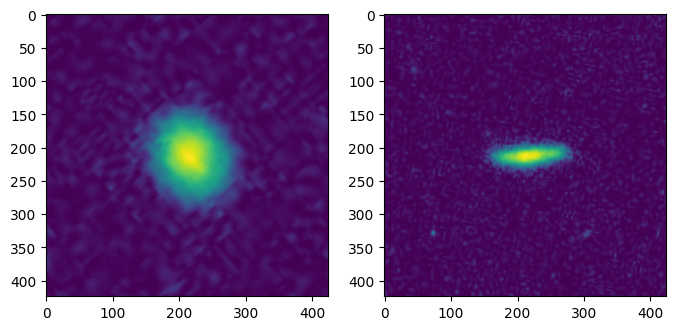

In [13]:
img_1 = np.random.randint(galaxy_data.shape[0])
img_2 = np.random.randint(galaxy_data.shape[0])

fig, fig_axis = plt.subplots(1, 2, figsize = (8, 16))

fig_axis[0].imshow(galaxy_data[[str(i) for i in range(424*424)]].to_numpy()[img_1].reshape(424, 424))
fig_axis[1].imshow(galaxy_data[[str(i) for i in range(424*424)]].to_numpy()[img_2].reshape(424, 424))

In [14]:
%%time
from src.remove_noise import cut_images
cut_images(galaxy_data)

CPU times: user 7.26 s, sys: 5.62 ms, total: 7.27 s
Wall time: 7.28 s


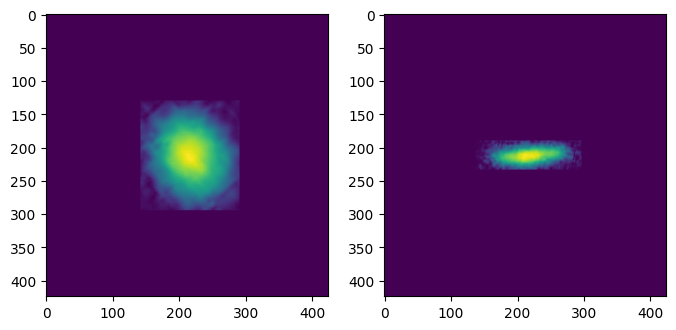

In [15]:
fig, fig_axis = plt.subplots(1, 2, figsize = (8, 16))

fig_axis[0].imshow(galaxy_data[[str(i) for i in range(424*424)]].to_numpy()[img_1].reshape(424, 424))
fig_axis[1].imshow(galaxy_data[[str(i) for i in range(424*424)]].to_numpy()[img_2].reshape(424, 424))

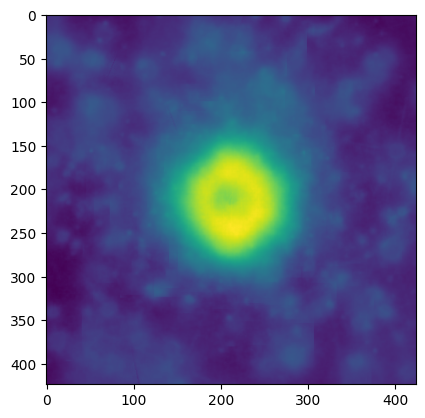

std Max: 32.080940489123236 
std min: 2.7068534418315955 
std mean: 9.68320822509389 
std std: 5.711159497420426 
std mean - std: 3.9720487276734646


In [16]:
std_pixels = np.std(galaxy_data[[str(i) for i in range(424*424)]], axis = 0).to_numpy()
plt.imshow(std_pixels.reshape(424, 424))
plt.show()
print("std Max:", std_pixels.max(), "\nstd min:", std_pixels.min(), "\nstd mean:", std_pixels.mean(), "\nstd std:", std_pixels.std(),"\nstd mean - std:", std_pixels.mean() - std_pixels.std())

In [17]:
# In this step we check different values of variance (0.001,0.1, 0.5) but the shape remain same.
from sklearn.feature_selection import VarianceThreshold

# Drop ID and target columns first
columns_to_drop = ['objid', 'gz2class']
feature_data = galaxy_data.drop(columns=columns_to_drop)

# Remove low-variance features
selector = VarianceThreshold(threshold=9)
feature_data = feature_data.loc[:, selector.fit(feature_data).get_support()]

print("Shape after removing low-variance features:", feature_data.shape)
print("differences features:", galaxy_data.shape[1] - feature_data.shape[1])

Shape after removing low-variance features: (1500, 179612)
differences features: 180


The Variance threshold has no effect on the features.

In [18]:
from sklearn.decomposition import PCA

# Select only pixel features (exclude first two columns and label)
pixel_data = feature_data.iloc[:, 2:-1]  

# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)  # Retain 95% of the variance
principal_components = pca.fit_transform(pixel_data)

# Create new dataframe with principal components
galaxy_data_pca = pd.DataFrame(principal_components)

# Reinsert metadata columns
galaxy_data_pca.insert(0, "objid", galaxy_data["objid"])
galaxy_data_pca.insert(1, "asset_id", galaxy_data["asset_id"])
galaxy_data_pca["gz2class"] = galaxy_data["gz2class"]

print(f"Original shape: {galaxy_data.shape}, Reduced shape with PCA: {galaxy_data_pca.shape}")

Original shape: (1500, 179792), Reduced shape with PCA: (1500, 188)


- **PCA reduced the number of features while still keeping **$95\%$ of the variance** in the data.
- The new reduce features are not individual pixels but **combination of pixels** that best explain the variation in the dataset.

---

### 5. Check how many clusters can be associated to the data points joint distribution using tSNE or UMAP. 

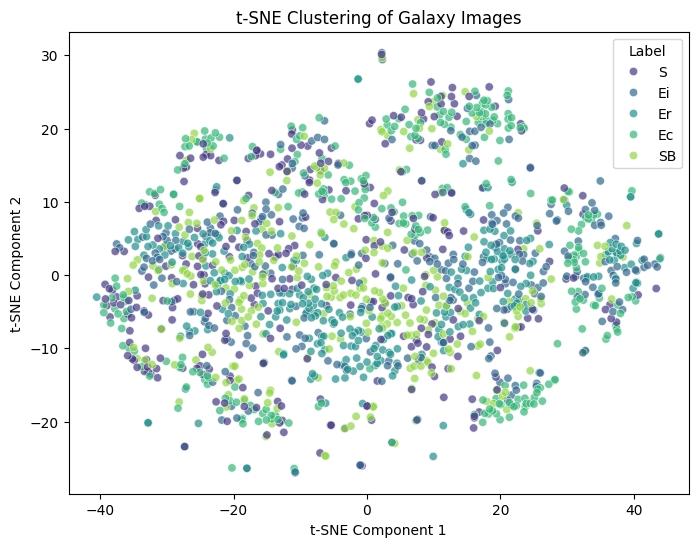

In [23]:
from sklearn.manifold import TSNE

# Convert PCA-reduced data to numpy array (excluding metadata columns)
X_pca = galaxy_data_pca.iloc[:, 2:-1].values  # Excluding "objectid", "asset_id", and "gz2class"

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200,random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=galaxy_data_pca["gz2class"], palette="viridis", alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Clustering of Galaxy Images")
plt.legend(title="Label")
plt.show()

**Conclusion**: Points are scattered randomly, this suggests weak separation, pixel features together with the symmetry features might not be enough.

In [20]:
%%time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# Load the dataset
#df = pd.read_csv("path_to_dataset.csv")  # Update with your dataset path

# Prepare the data
X = galaxy_data_pca.iloc[:, 2:-1].values
y = galaxy_data_pca["gz2class"].values

# Split the dataset into training and testing sets (80%-20% split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define different hyperparameters for experimentation
param_grid = {
'n_estimators':[50, 100, 200],  # Number of trees in the forest
'max_depth': [10, 20, None]  # Maximum depth of trees
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_


y_pred = best_rf.predict(X_test)

# Evaluate performance
from sklearn.metrics import accuracy_score
print("Best Model Accuracy:", accuracy_score(y_test, y_pred))

Best Model Accuracy: 0.43666666666666665
CPU times: user 1.44 s, sys: 973 ms, total: 2.41 s
Wall time: 5.28 s


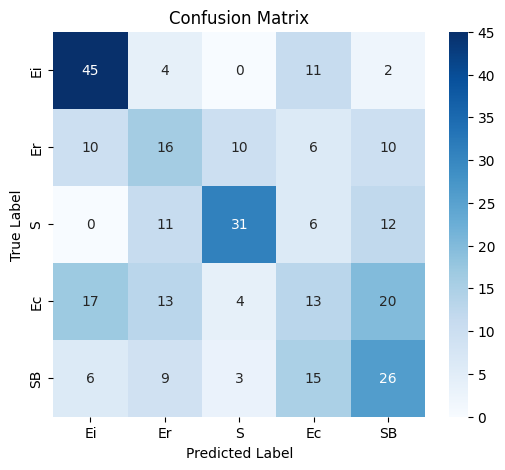

In [21]:
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=set(y), yticklabels=set(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [22]:
np.sum(confusion_matrix(y_test, y_pred), axis = 1)

array([62, 52, 60, 67, 59])